# Band Definitions

Neural oscillations vary in their center frequency, requiring that analyses check frequency ranges and consider individualized frequency bands. 

### Issue

Many analyses apply predefined frequency ranges to analyze bands of interest. Such predefined ranges may not reflect the variability of individual peak frequencies that we observe in neural field data. The use of predefined band ranges can lead to misestimations of oscillatory power, if peaks are not well captured. 

### Solution

Chosen frequency ranges for analyses of interest should be validated in the data to be analyzed. 

In at least some cases, individualized frequency ranges may need to be used to appropriately reflect the data. 

### Related Work

The following papers include discussion of this topic:
- [EEG alpha and theta oscillations reflect cognitive and memory performance: a review and analysis](https://doi.org/10.1016/S0165-0173(98)00056-3), Klimesch, 1999
- [The increase in theta/beta ratio on resting-state EEG in boys with ADHD is mediated by slow alpha peak frequency](https://doi.org/10.1016/j.pnpbp.2010.08.004), Lansbergen et al, 2011

### Related Discussion / Examples

The following other online examples / tutorials also discuss this topic:
- Band-by-band analyses of neural field data
    - https://fooof-tools.github.io/fooof/auto_motivations/measurements/plot_BandByBand.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

from fooof.utils import trim_spectrum
from fooof.plts.spectra import plot_spectrum_shading, plot_spectra_shading

from neurodsp.sim import sim_combined, sim_oscillation, sim_powerlaw
from neurodsp.filt import filter_signal
from neurodsp.spectral import compute_spectrum
from neurodsp.utils import remove_nans, create_times, set_random_seed
from neurodsp.timefrequency import amp_by_time, freq_by_time, phase_by_time
from neurodsp.plts.time_series import plot_time_series

In [2]:
# Add path and import custom code for the project
import sys
sys.path.append('code')
from utils import compute_abs_power, get_components
from plts import plot_bar, style_psd, savefig
from settings import BANDS, COND_COLORS, ALPHA_RANGE, ALPHA_COLOR, INDIV_COLOR

## Settings

In [3]:
import seaborn as sns
sns.set_context('poster')

In [4]:
# Set random seed
set_random_seed(808)

In [5]:
# Set the average function to use
avg_func = np.nanmedian
var_func = np.nanstd

In [6]:
# Define general simulation settings
n_seconds = 20
fs = 1000

times = create_times(n_seconds, fs)

In [7]:
# Define parameters for the simulations
exp = -1.5
ap_filt = (2, 50)

# Define center frequencies
cf1 = 10
cf2 = 8

# Define relative power of the signal components
comp_vars = [0.5, 1]

In [8]:
# Set frequency ranges of interest
psd_range = [3, 35]

In [9]:
# Analysis settings
nperseg = 1.5 * fs

In [10]:
# Plot settings
labels = ['sig-1', 'sig-2']
ms = 18

# Organize colors for plots
C1, C2 = COND_COLORS

In [11]:
# Set whether to save out figures
SAVE_FIG = False

## Simulate Time Series

First, we'll simulate some example data. 

Here, we will simulate two time series, each with an oscillation in them, but with slightly different center frequencies. 

In [12]:
# Simulate an aperiodic component
ap = sim_powerlaw(n_seconds, fs, exp, f_range=ap_filt, variance=0.5)

# Simulate periodic components
osc1 = sim_oscillation(n_seconds, fs, cf1)
osc2 = sim_oscillation(n_seconds, fs, cf2)

In [13]:
# Combine periodic and aperiodic components of the simulated signals
sig1 = ap + osc1
sig2 = ap + osc2

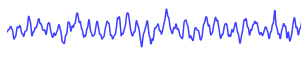

In [14]:
# Plot the first example signal
_, ax = plt.subplots(figsize=(6, 2))
plot_time_series(times, sig1, xlim=(5, 8), lw=1.5, alpha=0.75, colors=C1, ax=ax)
plt.axis('off')
savefig(SAVE_FIG, '02-ts-sig1_noax')

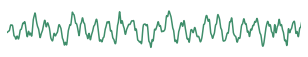

In [15]:
# Plot the second example signal
_, ax = plt.subplots(figsize=(6, 2))
plot_time_series(times, sig2, xlim=(5, 8), lw=1.5, alpha=0.75, colors=C2, ax=ax)
plt.axis('off')
savefig(SAVE_FIG, '02-ts-sig2_noax')

### Compute Power Spectra

Next, we will compute the power spectra, and compare the two signals. 

In particular, we will compare the peaks in the spectrum, to a canonically defined alpha range, shaded in blue. 

In [16]:
# Compute the power spectra of each of the example signals
freqs1, powers1 = trim_spectrum(*compute_spectrum(sig1, fs, nperseg=nperseg), psd_range)
freqs2, powers2 = trim_spectrum(*compute_spectrum(sig2, fs, nperseg=nperseg), psd_range)

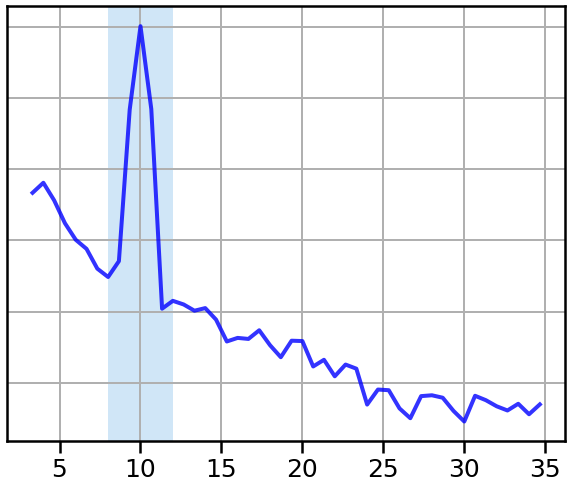

In [17]:
# Plot the power spectrum of the first signal
plot_spectrum_shading(freqs1, powers1, ALPHA_RANGE, log_powers=True,
                      color=C1, alpha=0.8, lw=4, shade_colors=ALPHA_COLOR)
style_psd(plt.gca())
savefig(SAVE_FIG, '02-psd_alpha_cen')

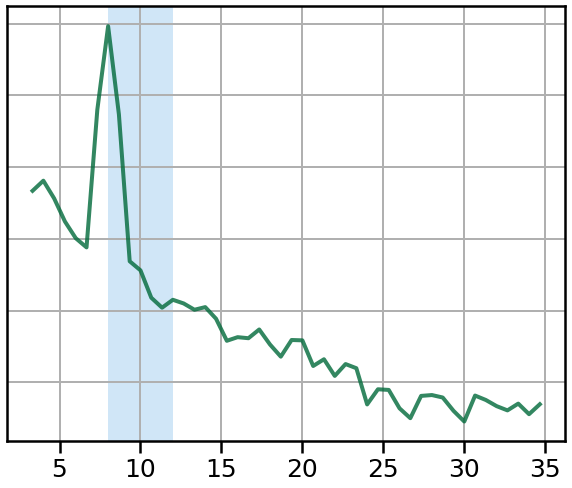

In [18]:
# Plot the power spectrum of the second signal
plot_spectrum_shading(freqs2, powers2, ALPHA_RANGE, log_powers=True,
                      color=C2, alpha=0.8, lw=4, shade_colors=ALPHA_COLOR)
style_psd(plt.gca())
savefig(SAVE_FIG, '02-psd_alpha_off')

In [19]:
# Plot an extra version of the PSD plot for signal 2, for the figure
plot_spectrum_shading(freqs2, powers2, ALPHA_RANGE, log_powers=True,
                      color='black', lw=4, shade_colors=ALPHA_COLOR)
style_psd(plt.gca(), clear_x=True)
savefig(SAVE_FIG, '02-psd_small_can')
plt.close()

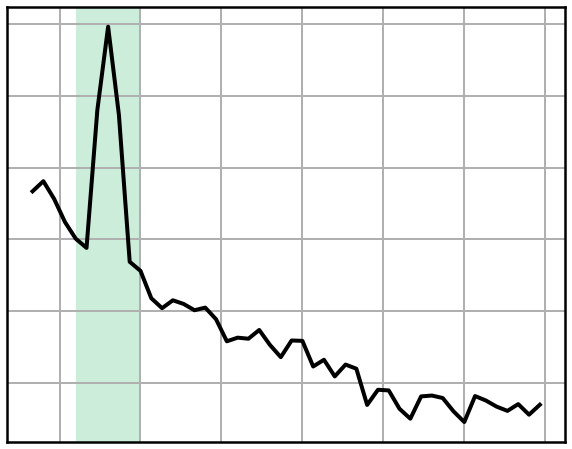

In [20]:
# Plot the individualized range of the second signal
plot_spectrum_shading(freqs2, powers2, [cf2-2, cf2+2], log_powers=True,
                      color='black', lw=4, shade_colors=INDIV_COLOR)
style_psd(plt.gca(), clear_x=True)
savefig(SAVE_FIG, '02-psd_small_indi')

### Compare Alpha Power Measures

Now, let's compare measures of alpha power on the simulated signal. 

We will compare alpha power computed from the power spectra, for both canonical and individualized ranges. 

In [21]:
# Check the canonical alpha range
print('Canonical alpha range:', ALPHA_RANGE)

Canonical alpha range: (8, 12)


In [22]:
# Compute the absolute alpha power in the canonical range
cal1 = compute_abs_power(freqs1, powers1, ALPHA_RANGE)
cal2 = compute_abs_power(freqs2, powers2, ALPHA_RANGE)

In [23]:
# Check calculated canonical alpha power
print("Canonical Alpha Power - Signal 1 \t: {:8.4f}".format(cal1)) 
print("Canonical Alpha Power - Signal 2 \t: {:8.4f}".format(cal2))
print("Difference in Canonical Alpha Power \t: {:8.4f}".format(cal2 - cal1))

Canonical Alpha Power - Signal 1 	:   1.6027
Canonical Alpha Power - Signal 2 	:   1.2670
Difference in Canonical Alpha Power 	:  -0.3357


In [24]:
# Compute the absolute alpha power in individualized ranges
ial1 = compute_abs_power(freqs1, powers1, [cf1-2, cf1+2])
ial2 = compute_abs_power(freqs2, powers2, [cf2-2, cf2+2])

In [25]:
# Check calculated individualized alpha power
print("Individualized Alpha Power - Signal 1 \t\t: {:8.4f}".format(ial1)) 
print("Individualized Alpha Power - Signal 2 \t\t: {:8.4f}".format(ial2))
print("Difference in Individualized Alpha Power \t: {:8.4f}".format(ial2 - ial1))

Individualized Alpha Power - Signal 1 		:   1.6027
Individualized Alpha Power - Signal 2 		:   1.5426
Difference in Individualized Alpha Power 	:  -0.0601


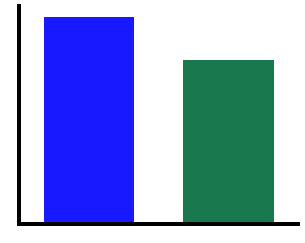

In [26]:
# Compare the measured power, using the canoncal alpha range
plot_bar(cal1, cal2, color=COND_COLORS, alpha=0.9, figsize=(5, 4))
savefig(SAVE_FIG, '02-can_alpha')

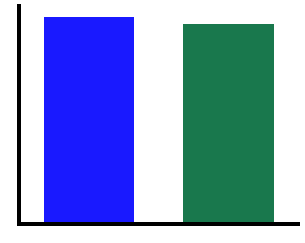

In [27]:
# Compare the measured power, using individualized alpha
plot_bar(ial1, ial2, color=COND_COLORS, alpha=0.9, figsize=(5, 4))
savefig(SAVE_FIG, '02-ind_alpha_on')

As we can see in the above, the measures of canonical alpha find different amounts of alpha power in the two signals, despite the simulated time series having been simulated with the same amount of oscillatory power. The individualized bands correctly show equivalent amounts of oscillatory power. 

### Compare Adjacent Bands

Oscillatory center frequencies that don't match canonical band definitions can also impact measures of adjacent bands. 

Here, we will measure measures of power in canonical theta and beta ranges. 

We will also compute power in individualized bands, defined by offsetting the band range with respect to the simulated alpha. 

Note that there were no theta and beta oscillations added to these simulations, and so measured power should not differ.

In [28]:
# Calculate power in the canonical theta band
cth1 = compute_abs_power(freqs1, powers1, BANDS.theta)
cth2 = compute_abs_power(freqs2, powers2, BANDS.theta)

In [29]:
# Check calculated canonical theta power
print("Canonical Theta Power - Signal 1 \t\t: {:8.4f}".format(cth1)) 
print("Canonical Theta Power - Signal 2 \t\t: {:8.4f}".format(cth2))
print("Difference in Canonical Theta Power \t: {:8.4f}".format(cth2 - cth1))

Canonical Theta Power - Signal 1 		:   0.2795
Canonical Theta Power - Signal 2 		:   1.4513
Difference in Canonical Theta Power 	:   1.1718


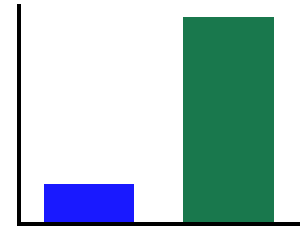

In [30]:
# Plot canonical theta
plot_bar(cth1, cth2, color=COND_COLORS, alpha=0.9, figsize=(5, 4))
savefig(SAVE_FIG, '02-can_theta')

In [31]:
# Calculate power in the canonical beta band
cbe1 = compute_abs_power(freqs1, powers1, BANDS.beta)
cbe2 = compute_abs_power(freqs2, powers2, BANDS.beta)

In [32]:
# Check calculated canonical beta power
print("Canonical Beta Power - Signal 1 \t\t: {:8.4f}".format(cbe1)) 
print("Canonical Beta Power - Signal 2 \t\t: {:8.4f}".format(cbe2))
print("Difference in Canonical Beta Power \t: {:8.4f}".format(cbe2 - cbe1))

Canonical Beta Power - Signal 1 		:   0.1223
Canonical Beta Power - Signal 2 		:   0.1223
Difference in Canonical Beta Power 	:   0.0000


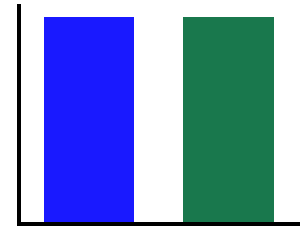

In [33]:
# Plot canonical beta
plot_bar(cbe1, cbe2, color=COND_COLORS, alpha=0.9, figsize=(5, 4))
savefig(SAVE_FIG, '02-can_beta')

In [34]:
# Calculate power in the individualized theta band
ith1 = compute_abs_power(freqs1, powers1, [cf1-6, cf1-2])
ith2 = compute_abs_power(freqs2, powers2, [cf2-6, cf2-2])

In [35]:
# Check calculated individualized theta power
print("Individualized Theta Power - Signal 1 \t\t: {:8.4f}".format(ith1)) 
print("Individualized Theta Power - Signal 2 \t\t: {:8.4f}".format(ith2))
print("Difference in Individualuzed Theta Power \t: {:8.4f}".format(ith2 - ith1))

Individualized Theta Power - Signal 1 		:   0.2795
Individualized Theta Power - Signal 2 		:   0.2828
Difference in Individualuzed Theta Power 	:   0.0033


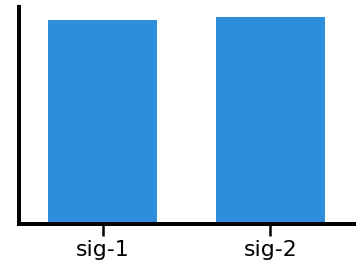

In [36]:
# Plot the comparison of individualized theta power
plot_bar(ith1, ith2, *labels, color=ALPHA_COLOR, alpha=0.9)

In [37]:
# Calculate power in the individualized beta band
ibe1 = compute_abs_power(freqs1, powers1, [cf1+3, cf1+20])
ibe2 = compute_abs_power(freqs2, powers2, [cf2+3, cf2+20])

In [38]:
# Check calculated individualized theta power
print("Individualized Beta Power - Signal 1 \t\t: {:8.4f}".format(ibe1)) 
print("Individualized Beta Power - Signal 2 \t\t: {:8.4f}".format(ibe2))
print("Difference in Individualuzed Beta Power \t: {:8.4f}".format(ibe2 - ibe1))

Individualized Beta Power - Signal 1 		:   0.1223
Individualized Beta Power - Signal 2 		:   0.1497
Difference in Individualuzed Beta Power 	:   0.0274


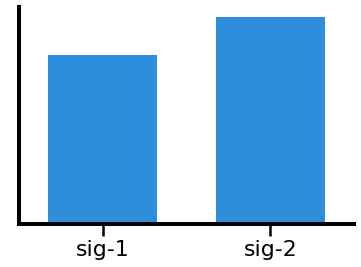

In [39]:
# Plot the comparison of individualized beta power
plot_bar(ibe1, ibe2, *labels, color=ALPHA_COLOR, alpha=0.9)

In the above, we can see that canonical theta, shows a difference in measured power due to the alpha peak "leaking" into the theta range. 

In this particular simulation, this does not happen for the beta range, as the simulated peaks do no overlap with beta. 

We can also see that the individualized bands appropriately show no significant differences in theta & beta power. 

Note that in the above, measures in which there are no peaks do not reflect zero power due to the aperiodic component.

## Run 'Group' Analysis

In the above comparison, we used comparisons between example signals. 

Next, let's run a simualted 'group' comparison, comparing between groups of signals with different center frequencies. 

For this comparison, we can imagine we are comparing two groups of subjects, one of which has a systematically different typical center frequency. 

We will compare these 'groups' using canonical and individualized alpha bands

In [40]:
# Set a number of simulations to run & compare
n_sims = 20

In [41]:
# Initialize variables to store computed measures
cal1, cal2 = [], []
ial1, ial2 = [], []

# Simulate a 'group' comparison, calculating alpha power measures on groups of signals
for ind in range(n_sims):

    cur_freqs1, cur_powers1 = compute_spectrum(\
        sim_combined(n_seconds, fs, get_components(cf1, exp, ap_filt), comp_vars), fs, nperseg=fs)
    cur_freqs2, cur_powers2 = compute_spectrum(\
        sim_combined(n_seconds, fs, get_components(cf2, exp, ap_filt), comp_vars), fs, nperseg=fs)
    
    cal1.append(avg_func(trim_spectrum(cur_freqs1, cur_powers1, ALPHA_RANGE)[1]))
    cal2.append(avg_func(trim_spectrum(cur_freqs2, cur_powers2, ALPHA_RANGE)[1]))
    
    ial1.append(avg_func(trim_spectrum(cur_freqs1, cur_powers1, [cf1-2, cf1+2])[1]))
    ial2.append(avg_func(trim_spectrum(cur_freqs2, cur_powers2, [cf2-2, cf2+2])[1]))

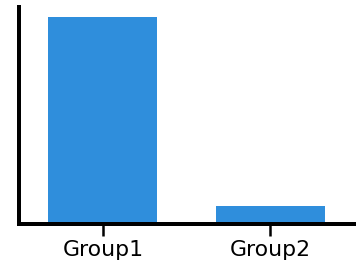

In [42]:
# Compare the measured power, using the canoncal alpha range
plot_bar(cal1, cal2, 'Group1', 'Group2', color=ALPHA_COLOR, alpha=0.9)
savefig(SAVE_FIG, '02-bar_canalpha')

In [43]:
# Compute a t-test comparison of the groups, using the canoncal alpha range
print('T-test - t-val: {:8.4f}, p-val: {:8.4f}'.format(*ttest_ind(cal1, cal2)))

T-test - t-val:  47.1578, p-val:   0.0000


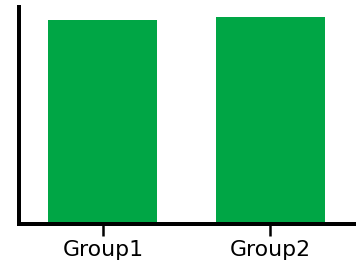

In [44]:
# Compare the measured power, using individualized alpha range
plot_bar(ial1, ial2, 'Group1', 'Group2', color=INDIV_COLOR)
savefig(SAVE_FIG, '02-bar_actalpha')

In [45]:
# Compute a t-test comparison of the groups, using individualized alpha range
print('T-test comparison - t-val: {:8.4f}, p-val: {:8.4f}'.format(*ttest_ind(ial1, ial2)))

T-test comparison - t-val:  -0.5132, p-val:   0.6108


In the above, we can see how a difference in frequency can lead to measuring a significant difference in power, when using canonical frequency bands.

## Compare Filtered Signals

Another way we can compare the impacts of differences in center frequencies is by looking at filtered data. 

Here, we will filter the signals, using canonical and individualized frequency ranges. 

Note that for the first signal, the canonical and individualized range are equivalent, so we will only show one. 

In [46]:
# Filter signals into the alpha range, including an individualized range
sig_filt1 = filter_signal(sig1, fs, 'bandpass', ALPHA_RANGE)
sig_filt2 = filter_signal(sig2, fs, 'bandpass', ALPHA_RANGE)

In [47]:
# Filter the second signal to an individualized alpha range
sig_filt2_ind = filter_signal(sig2, fs, 'bandpass', [cf2-2, cf2+2])

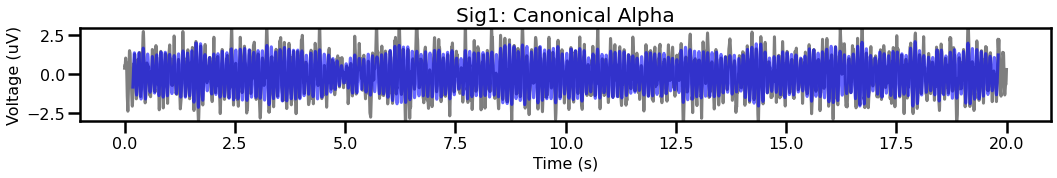

In [48]:
# Plot the first signal, with the corresponding filtered trace
plot_time_series(times, [sig1, sig_filt1], title='Sig1: Canonical Alpha',
                 colors=['k', 'b'], alpha=[0.5, 0.6], ylim=[-3, 3])

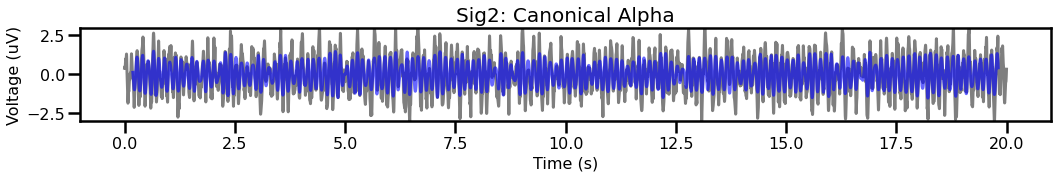

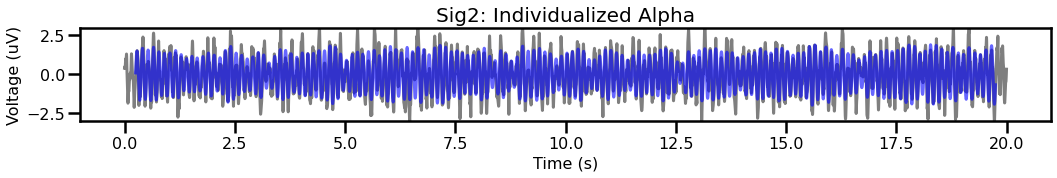

In [49]:
# Compare the filtered traces for signal 2, between canonical & individualized
plot_time_series(times, [sig2, sig_filt2], title='Sig2: Canonical Alpha',
                 colors=['k', 'b'], alpha=[0.5, 0.6], ylim=[-3, 3])
plot_time_series(times, [sig2, sig_filt2_ind], title='Sig2: Individualized Alpha',
                 colors=['k', 'b'], alpha=[0.5, 0.6], ylim=[-3, 3])

For the second signal, comparing canonical and individualized ranges shows that the individualized range captures more of the data. 

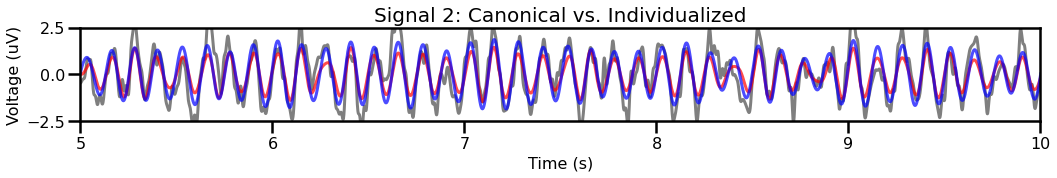

In [50]:
# Zoom in & compare within the second signal between canonical & individualized
title = "Signal 2: Canonical vs. Individualized"
plot_time_series(times, [sig2, sig_filt2, sig_filt2_ind], title=title,
                 colors=['k', 'r', 'b'], alpha=[0.5, 0.7, 0.7],
                 xlim=[5, 10], ylim=[-2.5, 2.5])

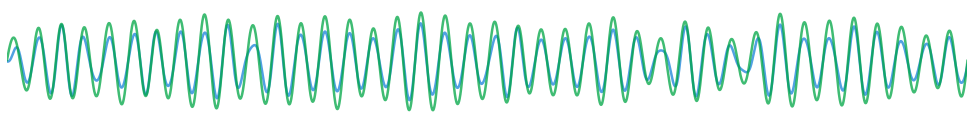

In [51]:
# Plot the two filtered traces (canonical and individualized)
plot_time_series(times, [sig_filt2, sig_filt2_ind],
                 colors=[ALPHA_COLOR, INDIV_COLOR], lw=2.5,
                 alpha=0.75, xlim=[5, 10])
plt.axis('off');
savefig(SAVE_FIG, '02-ts-filt')

## Compare Instantaneous Measures

To quantify our comparisons from the filter examples, we can use instantaneous measures. 

Here, we will compute amplitude and frequency measures, and compare the average results. 

In [52]:
# Calculate instantaneous measures of amplitude
amp1 = amp_by_time(sig_filt1, fs)
amp2 = amp_by_time(sig_filt2, fs)
amp2_ind = amp_by_time(sig_filt2_ind, fs)

In [53]:
# Check measures of instantaneous amplitude
print('Avg amp: Sig1 (canonical):  \t {:1.4f}'.format(avg_func(amp1)))
print('Avg amp: Sig2 (canonical):  \t {:1.4f}'.format(avg_func(amp2)))
print('Avg amp: Sig2 (individual): \t {:1.4f}'.format(avg_func(amp2_ind)))

Avg amp: Sig1 (canonical):  	 1.4229
Avg amp: Sig2 (canonical):  	 1.0111
Avg amp: Sig2 (individual): 	 1.4264


Again, we can see that the alpha measures are equivalent when individualized (but different with the canonical range). 

In [54]:
# Calculate instanenous measures of frequency
fre1 = freq_by_time(sig_filt1, fs)
fre2 = freq_by_time(sig_filt2, fs)
fre2_ind = freq_by_time(sig_filt2_ind, fs)

In [55]:
# Check measures of instantaneous frequency - signal1
print('True freq - sig1:  \t\t{:8.2f}'.format(cf1))
print('Avg  freq - sig1 (canonical):  \t{:8.2f} \t{:8.2f}'\
      .format(avg_func(fre1), var_func(fre1)))

True freq - sig1:  		   10.00
Avg  freq - sig1 (canonical):  	    9.97 	    1.67


In [56]:
# Check measures of instantaneous frequency - signal2
print('True freq - sig2:  \t\t{:8.2f}'.format(cf2))
print('Avg  freq - sig2 (canonical):  \t{:8.2f} \t{:8.2f}'\
      .format(avg_func(fre2), var_func(fre2)))
print('Avg  freq - sig2 (individual): \t{:8.2f} \t{:8.2f}'\
      .format(avg_func(fre2_ind), var_func(fre2_ind)))

True freq - sig2:  		    8.00
Avg  freq - sig2 (canonical):  	    8.09 	    0.70
Avg  freq - sig2 (individual): 	    7.98 	    0.28


Individualized frequency measures can only measure frequencies within the narrow-band band range they see.

This means they can be biased if the true frequencies at at or near the edge of this range, as we can see in the above. 

### Sweep across center frequencies

In the examples above, we have used two different center frequencies to compare measures. 

Center frequencies can of course vary more continously. 

In this example, we will simulate signals and compare measures across a range of alpha center frequencies. 

In [57]:
# Initialize stores for measures
outs_can = []
outs_ind = []
powers = []
ths = []
bes = []

In [58]:
# Simulate signals across a range of alpha center frequencies, and collect measures
cfs = np.arange(6, 15)
for cf in cfs:
    
    sig = sim_combined(n_seconds, fs, get_components(cf, exp, ap_filt), comp_vars)
    
    _, pows = trim_spectrum(*compute_spectrum(sig, fs, nperseg=nperseg), psd_range)
    powers.append(pows)
    
    outs_can.append(avg_func(amp_by_time(sig, fs, ALPHA_RANGE)))
    outs_ind.append(avg_func(amp_by_time(sig, fs, [cf-2, cf+2])))
    
    ths.append(avg_func(amp_by_time(sig, fs, BANDS.theta)))
    bes.append(avg_func(amp_by_time(sig, fs, BANDS.beta)))

/Users/tom/opt/anaconda3/lib/python3.8/site-packages/neurodsp/filt/checks.py:172: UserWarning: Transition bandwidth is  4.0  Hz. This is greater than the desiredpass/stop bandwidth of  4.0 Hz
  warn('Transition bandwidth is  {:.1f}  Hz. This is greater than the desired'\


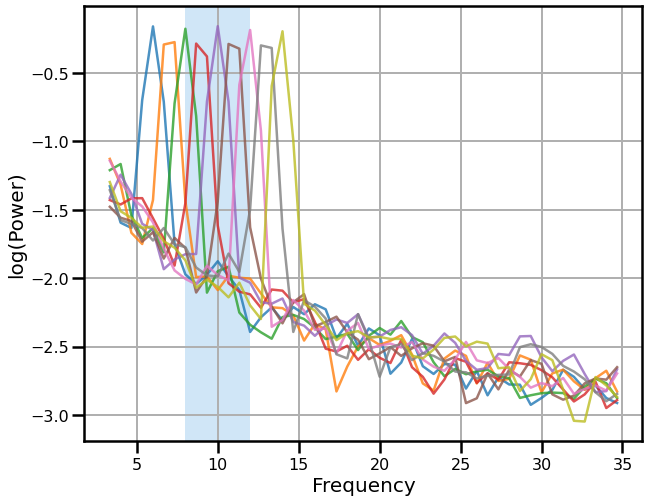

In [59]:
# Plot the power spectra of the signals across different center frequencies
plot_spectra_shading(freqs1, powers, ALPHA_RANGE, ALPHA_COLOR,
                     lw=2.5, log_powers=True, alpha=0.8)
savefig(SAVE_FIG, '02-psds_all')

### Compare band power measures across simulated signals

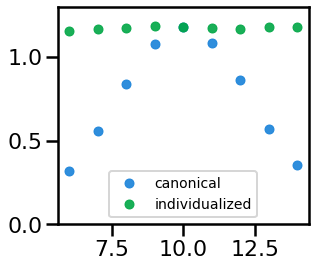

In [60]:
# Plot the measured alpha power (canonical & individualized) across alpha CF
_, ax = plt.subplots(figsize=(4.5, 4))
ax.plot(cfs, outs_can, '.', ms=ms, alpha=0.9, color=ALPHA_COLOR, label='canonical')
ax.plot(cfs, outs_ind, '.', ms=ms, alpha=0.9, color=INDIV_COLOR, label='individualized')
ax.set_ylim([0, 1.30]);
plt.legend(loc=8, prop={'size': 14})
savefig(SAVE_FIG, '02-alpha_power')

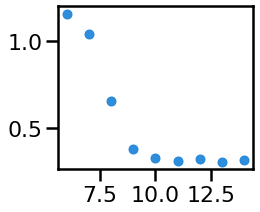

In [61]:
# Plot the measured 'theta' power from across varying alpha CF
_, ax = plt.subplots(figsize=(3.5, 3))
ax.plot(cfs, ths, '.', ms=ms, alpha=0.9, color=ALPHA_COLOR)
savefig(SAVE_FIG, '02-theta_power')

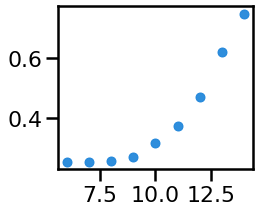

In [62]:
# Plot the measured 'beta' power from across varying alpha CF
_, ax = plt.subplots(figsize=(3.5, 3))
ax.plot(cfs, bes, '.', ms=ms, alpha=0.9, color=ALPHA_COLOR)
savefig(SAVE_FIG, '02-beta_power')

## Conclusion

Neural oscillations are often analyzed using pre-defined band ranges of interest.

Here, we have explored a series of limitations whereby if these ranges do not appropriately reflect the actual center frequencies of the data, then measures of interest may be confounded, for example, differences in center frequency can be look like a difference in power. 

Chosen frequency ranges should always be validated on the data to be analyzed. In some cases, individualized frequency ranges may be required in order to better capture the data. 